# Corruption Prediction Based on the Audit Documents 

### Backgroud
This project is motivated by the paper 'The Political Resource Curse' which studies the effect of additional government spending on the political corruptions in Brazil. The authors of the paper labeled each munincipality as corrupted or clean by reading audit documents. The purpose of this project is to predict the corruption of unlabeled munincipality based on the remaining audit documents, by using the already labeled audit documents as training dataset. Note that the audit documents are the products of 'Brazilian anti-corruption program' and only cover the randomly selected munincipalities.

### Data
- txt.zip - zip file containing the 2002 text files of audit documents
- corruption_data.csv file containing the data on which munincipalities are corrupted
- report_id_and_mun_code.csv text data which matches the report_id(audit document) and munincipality

### Preprocessing
First of all, we will preprocess all the audit documents so that they will be ready for visualization, feature extraction and classification.We will do the following for the preprocessing:
- **lowering** the letters
- removing **numbers**
- removing **non-alphanumeric characters**
- removing **underscores**
- removing **stop words** (We will use NLTK to create a list of stop words)

Then, we will lemmatize the documents by using spacy. Note that since each document is too large to be lemmatized, we will split each document into 5 sub documents to be processed.  


First we will build helper functions for preprocessing

In [17]:
import nltk
import re
from nltk.corpus import stopwords
import spacy
import pt_core_news_sm
import math

# getting a list of stopwords
stop = stopwords.words('portuguese')
#getting the lemmatizer
nlp = pt_core_news_sm.load()

## Helpher method for the preprocess to join a text
def join(text):
    return ' '.join(word for word in text)

## Method for preprocessing the document
def preprocess(text):
    #lowercase the text
    text = text.lower()
    #remove number
    text = re.sub(r'\d+', '', text)
    #remove non-alphabetical letter
    text = re.sub(r'[^\w\s]', ' ',text )
    #get rid of the underscore
    text = text.replace('_'," ")
    #get rid of a special letter in portuguese
    text = text.replace('nº'," ")
    #removes stopword and a single letter
    l = [w for w in text.split() if w not in stop and len(w)>1]
    return join(l)

## Method for lemmatizing a document
def lemmatizer(text):
    text = text.split()
    text1 = join(text[0:math.floor(len(text)/5)])
    text2 = join(text[math.floor(len(text)/5):math.floor(2*len(text)/5)])
    text3 = join(text[math.floor(2*len(text)/5):math.floor(3*len(text)/5)])
    text4 = join(text[math.floor(3*len(text)/5):math.floor(4*len(text)/5)])
    text5 = join(text[math.floor(4*len(text)/5):])

    text1 = nlp(text1)
    l1 = [word.lemma_ for word in text1]
    text2 = nlp(text2)
    l2 = [word.lemma_ for word in text2]
    text3 = nlp(text3)
    l3 = [word.lemma_ for word in text3]
    text4 = nlp(text4)
    l4 = [word.lemma_ for word in text4]
    text5 = nlp(text5)
    l5 = [word.lemma_ for word in text5]
    return join(l1) + " " + join(l2) + " " + join(l3) + " " + join(l4) + " " + join(l5)

Now let's read the audit documents as text and merge them with target label(0,1)

In [14]:
import pandas as pd
import zipfile
import os


## reading the report data 
path = "txt.zip"
zip_ref = zipfile.ZipFile(path,'r')
zip_ref.extractall('data/reports')
df = pd.DataFrame()
num = 1
basepath = 'data/reports'
while True:
    path = os.path.join(basepath,str(num)+'.txt')
    try:
        f = open(path,"r",encoding='utf-8')
        contents = f.read()
        df = df.append([[contents,num]],ignore_index = True)
        num = num+1
    except:
        break
df.columns = ['contents','report_id']

## reading the reference data(municipality_id to report_id) for the later merge
basepath = 'data/corruption'
path = os.path.join(basepath,'report_id_and_mun_code.csv')
df2 = pd.read_csv(path)

##reading the corruption data(label)
path = os.path.join(basepath,'corruption_data.csv')
df3 = pd.read_csv(path,encoding = 'utf-8');

## merge the report data with reference data, attach corresponding munincipality_id
df = df.merge(df2, on = 'report_id');

##create dataset consisting of 2 classes 'narrow' and 'broad' corruption with munincipality_id
broad = pd.DataFrame(df3.groupby(['id_city'], sort=False)['broad'].max())
narrow = pd.DataFrame(df3.groupby(['id_city'], sort=False)['narrow'].max())
df4 = broad.merge(narrow,on = 'id_city')

## merge the label class data to the text data
df = df.merge(df4,left_on= 'mun_code', right_on = 'id_city')


Now, let's preprocess and lemmatize the audit document.


In [18]:
df = df[['contents','mun_code','broad','narrow', 'report_id']]

## preprocess the text data
df['contents'] = df['contents'].apply(preprocess)
## lemmatize the text data
df['contents'] = df['contents'].apply(lemmatizer)

## saves the preprocessed data as csv
df.to_csv('data/corruption/processed.csv',index = False,encoding = 'utf-8')

We will now process information about the document such as number of pages and images per document from the raw data.

In [29]:
## reading the report data 
import fitz

df_feature = pd.DataFrame();
num = 1

basepath = 'data/report_pdf'
while True:
    path = os.path.join(basepath,str(num)+'.pdf')
    try:
        doc = fitz.open(path)
        num_img = 0
        page = len(doc)
        for i in range(len(doc)):
            num_img += len(doc.getPageImageList(i))
        df_feature = df_feature.append([[num_img,page,num]],ignore_index = True)
        num = num+1
    except:
        break


In [146]:
df_feature.columns = ['num_img','page','report_id']

## merges the feature data with the text data
df = df.merge(df_feature, on = 'report_id');
## saves the preprocessed data as csv
df.to_csv('data/corruption/processed.csv',index = False,encoding = 'utf-8')

### Data Analysis
Before jumping into the classification, let's look at the basic summary of the data
- basic statistics
- statistics on word frequency


In [21]:
df.head()

,contents,mun_code,broad,narrow,report_id,num_img,page
0,presidência repúblico controladoria geral uniã...,2201739,1,0,1861,10,115
1,presidência repúblico controladoria geral uniã...,3165404,0,0,823,11,38
2,presidência repúblico controladoria geral uniã...,4213401,1,1,492,22,68
3,presidência repúblico controladoria geral uniã...,2504900,1,0,472,17,65
4,presidência repúblico controladoria geral uniã...,4104907,0,0,419,15,47


Variable "contents" is the actual content of the document, and the narrow variable is the target variable indicating if the munincipality is corrupt or not(1: corrupt, 0: otherwise)

In [124]:
## counts the number of documents for corrupted and clean munincipalities
nclean = len(df[df['narrow']==0])
nnarrow = len(df[df['narrow']==1])
print('Total number of total documents: ',len(df))
print('Total number of documents for corrupted muncipalities: ', nnarrow)
print('Total number of documents for clean muncipalities: ', nclean)

Total number of total documents:  1682
Total number of documents for corrupted muncipalities:  943
Total number of documents for clean muncipalities:  739


We have relatively balanced dataset. Let's now look at how diverse the words are across documents

In [125]:
from keras.preprocessing.text import Tokenizer
import operator

## reads the preprocessed data
df = pd.read_csv('data/corruption/processed.csv',encoding = 'utf-8')

## creating the tokenizer objects
c = Tokenizer()
n = Tokenizer()

# fit the tokenizer on the documents
c.fit_on_texts(df[df['narrow'] == 0]['contents'])
n.fit_on_texts(df[df['narrow'] == 1]['contents'])

cor= set(c.word_counts.keys())
nar = set(n.word_counts.keys())
print('Numner of words for corrupted :', len(cor))
print('Numner of words for clean :', len(nar))
print('Number of words in total', len(cor.union(nar)))


Numner of words for corrupted : 24184
Numner of words for clean : 28133
Number of words in total 29202


There does not seem to be much differences in the variety of words used in both documents. There also seems to be lots of overlapping words.


We will now see how long each documents are

In [172]:
import statistics as stat
df['length'] = df['contents'].apply(len)

print('The maximum length is ', max(df['length']))
print('The minimum length is ', min(df['length']))

print('The median length of documents for corrupt munincipalitie is: ',stat.median(df[df['narrow'] == 1]['length']))
print('The median length of documents for clean munincipalitie is: ',stat.median(df[df['narrow'] == 0]['length']))


The maximum length is  1179368
The minimum length is  3173
The median length of documents for corrupt munincipalitie is:  126986
The median length of documents for clean munincipalitie is:  83848


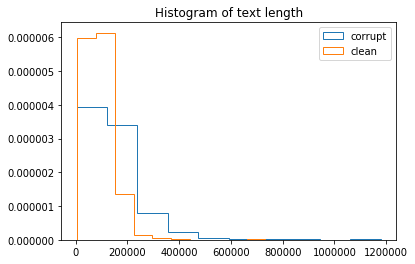

In [198]:
import matplotlib.pyplot as plt
plt.hist(df[df['narrow'] == 1]['length'],normed = True,histtype = 'step',label = 'corrupt')
plt.hist(df[df['narrow'] == 0]['length'],normed = True,histtype = 'step',label = 'clean')
plt.title('Histogram of text length')
plt.legend()


It seems that audit documents for corrupt municipalities is much longer than the one for clean munincipalities

Now let's see what words appear most frequently in documents for corrupted and clean munincipalities

In [149]:
from googletrans import Translator

## order the appearing word items by frequency
corrupt_narrow = sorted(n.word_counts.items(), key=operator.itemgetter(1),reverse = True)
clean = sorted(c.word_counts.items(), key=operator.itemgetter(1),reverse = True)

## translate the most frequent words
translator = Translator()
translated = translator.translate(text = 'medir',src = 'pt',dest = 'en')

## method for translating each word
def trans(text):
    translator = Translator()
    translated = translator.translate(text,src= 'pt',dest='en')
    return translated.text

## making a list of translated words from the most frequent words for clean munincipalities
transclean = {}
words = dict(clean[:20]).keys()
for word in words:
    freq = dict(clean).get(word)
    transclean[trans(word)] = freq    
    
## making a list of translated words from the most frequent words for corrupted munincipalities
transcorrupt = {}
words = dict(corrupt_narrow[:20]).keys()
for word in words:
    freq = dict(corrupt_narrow).get(word)
    transcorrupt[trans(word)] = freq   

Most frequent words in audit reports for corrupted munincipalities

In [151]:
transcorrupt

{'municipal': 211702,
 'resource': 195291,
 'control': 146026,
 'public': 130882,
 'schedule': 122672,
 'unity': 101915,
 'federal': 116652,
 'secretary': 115879,
 'town hall': 109077,
 'intern': 108976,
 'finding': 106874,
 'County': 106509,
 'to be': 104541,
 'application': 100938,
 'fact': 100721,
 'general': 95852,
 'controllership': 93182,
 'greet': 92412,
 'service': 89361}

Most frequent words in audit reports for non-corrupt munincipalities

In [150]:
transclean

{'municipal': 105198,
 'resource': 102663,
 'schedule': 81386,
 'control': 73101,
 'public': 69806,
 'County': 67164,
 'federal': 61993,
 'secretary': 58821,
 'inspection': 55333,
 'town hall': 54119,
 'unity': 44209,
 'greet': 53343,
 'fact': 51385,
 'intern': 51262,
 'general': 50189,
 'application': 49687,
 'controllership': 48760,
 'to be': 47201,
 'finding': 45340}

hmm.. the frequently appearing words do not differ much between the corrupt munincipalities and clean munincipalities.
Let's sort the words by IDF

In [81]:
import numpy as np

## For the clean municipalities
## Calculate the idf
ctext = c.texts_to_matrix(df[df['narrow'] == 0]['contents'])
idf = np.log(c.document_count/(1+sum(ctext)))
## sort the words by IDF
newword_clean = {}
words= c.word_counts.keys()
for word in words:
    newword_clean[word]  = c.word_counts.get(word)*idf[c.word_index.get(word)-1]   
clean = sorted(newword_clean.items(), key=operator.itemgetter(1),reverse = True)


## For the corrupt municipalities
## Calculate idf
ntext  =  n.texts_to_matrix(df[df['narrow'] == 1]['contents'])
idf = np.log(n.document_count/(1+sum(ntext)))
## Sort the words by IDF
newword = {}
words= n.word_counts.keys()
for word in words:
    newword[word]  = n.word_counts.get(word)*idf[n.word_index.get(word)-1]   
corrupt = sorted(newword.items(), key=operator.itemgetter(1),reverse = True)

## making a list of translated words from the most frequent words for clean munincipalities
transclean = {}
words = dict(clean[:30]).keys()
for word in words:
    idf = dict(clean).get(word)
    transclean[trans(word)] = idf   
    
## making a list of translated words from the most frequent words for corrupted munincipalities
transcorrupt = {}
words = dict(corrupt[:30]).keys()
for word in words:
    idf = dict(corrupt).get(word)
    transcorrupt[trans(word)] = idf

Again, let's see the sorted list of words by tfid

Highest TFIDF words in reports for corrupted munincipalities

In [91]:
transcorrupt

{'municipal': 1449961.0301660683,
 'to receive': 25643.243889247526,
 'measure': 19287.887741849838,
 'basic': 18112.790431703084,
 'sample': 17470.258938323845,
 'administrative': 17217.612054678517,
 'fix': 12070.20868692855,
 'last': 11426.632592027092,
 'pray': 9632.38860007867,
 'pharmaceutical': 9248.624213766905,
 'to engineer': 9222.520812774343,
 'corrective': 9022.636808824016,
 'total': 8492.834318043431,
 'consider': 8483.324437518393,
 'list': 7645.324093488712,
 'totality': 7436.28606968742,
 'motivate': 7308.480709658138,
 'base': 7142.4384504432965,
 'education': 6334.727223002882,
 'sound': 6249.240100083505,
 'quarantine': 5835.247587366123,
 'knowledge': 5768.071287661438,
 'bigger': 5614.166092441872,
 'OMG': 5603.11496676232,
 'to distribute': 5451.858202111344,
 'transf': 5450.187464252229,
 'third': 5412.783562816628,
 'module': 5399.6742426847095,
 'economy': 5393.083351039594,
 'recreation': 5375.85870782454}

Highest TFIDF words in reports for corrupted munincipalities

In [92]:
transclean

{'municipal': 694864.1306879089,
 'physicist': 13220.7623263255,
 'peti': 11532.909903042308,
 'documentation': 7873.648800526305,
 'young': 6422.302483053103,
 'worker': 6147.412631445394,
 'December': 6117.224257573882,
 'install': 5904.702927912213,
 'understand': 5763.59987829596,
 'ten': 5440.516106535588,
 'source': 5326.55657363016,
 'fax': 5255.31337188008,
 'go along': 5244.407604405705,
 'Antonio': 5192.702177320015,
 'Restroom': 4910.4031625014195,
 'tell': 4828.77691510397,
 'elide': 4814.723547316084,
 'settlement': 4607.438444512516,
 'establishment': 4380.279739562642,
 'laugh': 4293.372951623291,
 'to feed': 4291.615943400998,
 'job': 4246.372255592074,
 'Mount': 4224.135072043043,
 'release': 4089.2925733193274,
 'to adopt': 4048.091218207125,
 'installation': 3895.2425778622646,
 'supply': 3884.741931565225,
 'to file': 3861.393864261163,
 'emef': 3853.7525261200367,
 'manifest': 3778.277282996834}

Note:
PETI stands for Programa de Erradicação do Trabalho Infantil (PETI). It is a conditional cash transfer programme with emphasis on child labor

We can see that after sorting the words by tfid(term frequency inverse document frequency), there appear to be differences in the words in documents for corrupted munincipaities and clean munincipalities.

However, it is hard to pinpoint which words could be distinguishing corrupt munincipalities from clean munincipalities, sinece we have not considered negations. (e.g. 'distribute' could actually appear as 'do not distribute' in the orininal text). This may be better to use 2 bag of words for the classification



## Classification
Finally, let's train predictive models.
We will first try with a basic model where each document is classified simply based on the presence of the word "corrupt" and its synonyms

### Base Classifier

In [11]:
from googletrans import Translator
from nltk.corpus import wordnet
from sklearn.linear_model import LogisticRegression

## helper function to translate from English to Portuguese
def trans(text):
    translator = Translator()
    translated = translator.translate(text,src= 'en',dest='pt')
    return translated.text
## helper function to check if the document contains the word corrupt
def containsText(text):
    for syn in synonymPT:
        if syn in text:
            return 1
    return 0

# Obtains the list of sysnonyms of "corrupt" in English
syns = wordnet.synsets("corrupt")
synonyms = []
for syn in syns:
		for l in syn.lemmas():
			synonyms.append(l.name())

# Translate each word in Portuguese
synonymsPT = []
for word in synonyms:
    tr = trans(word)
    synonymsPT.append(tr)
synonymPT = set(synonymsPT)

## create a new variable contains (1 if there exists a word "corrupt" or its sysnomyms, 0 otherwise)
df['contains'] = df['contents'].apply(containsText)

## divide them into training and test data
y = np.array(df['narrow'].values).reshape(-1,1)
X = np.array(df['contains'].values).reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lr_base = LogisticRegression(random_state = 0, solver = 'lbfgs').fit(X_train,Y_train
score = lr_base.score(X_test,Y_test)
print("Test prediction accuracy for base classifier: %.3f"% score)

Test prediction accuracy for base classifier: 0.561


C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Text Classifier

Let's now classify the document based on the text

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

# read the preprocessed data
df = pd.read_csv('data/corruption/processed.csv',encoding = 'utf-8')


## divide them into training and test data
y = df['narrow'].values
X = df['contents'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [2]:
## Default Vectorizer 
tfidf = TfidfVectorizer(use_idf = True, max_df = 0.95, min_df = 0.05)

## Logistic Regression
LRpipe = Pipeline([('vect', tfidf),
                    ('clf',LogisticRegression(random_state = 0))])
param_grid = [{'vect__ngram_range': [[1,2],[2,3]],
               'clf__penalty':['l1', 'l2'],
               'clf__C':[1.0, 10.0,100.0]}]
gs_lr_tfidf = GridSearchCV(LRpipe, param_grid,scoring = 'accuracy', cv = 3, verbose = 1, n_jobs = -1)
gs_lr_tfidf.fit(X_train,Y_train)
lrclf = gs_lr_tfidf.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 29.6min finished
C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [5]:
## For SVC with linear kernel
SVMpipe = Pipeline([('vect', tfidf),('SVM', svm.SVC(kernel = 'linear',probability = True))])

param_grid = {
    'vect__ngram_range':[[1,2],[2,3]],
    'vect__min_df':[0.05],
    'vect__max_df':[0.95],
    'SVM__C': [0.01, 0.1, 1,10]
}
                    
SVM = GridSearchCV(SVMpipe,param_grid,cv=3,n_jobs = 1)
SVM.fit(X_train,Y_train)
svcclf = SVM.best_estimator_

In [8]:
##Naive Bayes
NBpipe = Pipeline([('vect', tfidf),
                   ('clf',MultinomialNB())])
param_grid = {
    'vect__ngram_range':[[1,2],[2,3]],
    'vect__min_df':[0.05],
    'vect__max_df':[0.95],
    'clf__alpha': [1, 1e-1, 1e-2]
}

NB = GridSearchCV(NBpipe,param_grid,cv=3,n_jobs = 1)
NB.fit(X_train,Y_train)
NBclf = NB.best_estimator_

In [ ]:
##XGBOOST
import xgboost as xgb
XGBpipe = Pipeline([('vect', tfidf),
                   ('clf',xgb.XGBClassifier(scale_pos_weight = 1, learning_rate = 0.1,reg_alpha = 0.3, max_depth = 6,n_estimators = 100,subsample = 1))])
param_grid = {
    'vect__ngram_range':[[1,2]],
    'vect__min_df':[0.05],
    'vect__max_df':[0.95],
    'clf__colsample_bytree': [0.3, 0.4, 0.5],
    'clf__gamma':[0,1,3],
    'clf__reg_alpha':[0,0.1,0.5]
}

XGB = GridSearchCV(XGBpipe, param_grid,cv = 3, n_jobs = -1)
XGB.fit(X_train,Y_train)
XGBclf = XGB.best_estimator_

Saving the classifiers for the future use

In [12]:
import pickle
## saving the fitted models for future use
filenames = ['lr_model.sav', 'svm_model.sav','nb_model.sav','xgb_model.sav']
models = [lrclf, svcclf, NBclf, XGBclf]
for i in range(len(filenames)):
    pickle.dump(models[i], open(filenames[i], 'wb'))
    

Loading the saved classifiers

In [1]:
import pickle
models = {}
filenames = ['lr_model.sav', 'svm_model.sav','nb_model.sav','xgb_model.sav']
for file in filenames:
    model = pickle.load(open(file, 'rb'))
    models[file[:-4]] = model
clflist = []
for model in models:
    clflist.append((model,models[model]))    

In [3]:
scores = []
print("Printing text scores for each classifiers")
for model in models:
    score = models.get(model).score(X_test,Y_test)
    print("%s : %.3f" %(model, score))
    scores.append(score)

Printing text scores for each classifiers
lr_model : 0.673
svm_model : 0.673
nb_model : 0.649
xgb_model : 0.710


XGB has the best test accuracy score. They all perform better than our base model with the accuracy of 56 %

## Adding features to the input variable
Let's now add a features such as the number of images per document and the length of the document

We will implement this by using Pipeline with customized transformers. We will approach this in 2 different ways.
1. merge the vectorized text with feature variables(# of images and pages) as input
2. implement separate classifiers for text data and feature data, then we will take majority vote(soft).

We will first implement custome transformer classes to be used in our pipelines

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


import numpy as np
import pandas as pd
df = pd.read_csv('data/corruption/processed.csv',encoding = 'utf-8')

y = df['narrow'].values
X = df
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)

##helper function to return the word counts per document
def textlength(text):
    return len(text.split())

# Custom transformer to create new variable of length of each document
class NumericalTransformer(BaseEstimator, TransformerMixin):
 
    #class Constructor
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    
    def transform(self,X, y = None):
        con = X.loc[:,'contents']
        page = np.array(X.loc[:,'page']).reshape(-1,1)
        img = np.array(X.loc[:,'num_img']).reshape(-1,1)
        l = np.array(con.apply(textlength)).reshape(-1,1)
        l = np.hstack([l,page,img])
        return l
# Custon transformer to extract text 
class DocumentSelector(BaseEstimator, TransformerMixin):
 
    #class Constructor
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    
    def transform(self,X, y = None):
        text = X['contents']
        return text
    
# Custom transformer to vectorize the text data into sparse matrix
class TfidfTransformer():
    def __init__(self,max_df = 0.9):
        self.max_df = max_df
        
    def fit(self,X,Y = None):
        return self
    
    def transform(self,X,Y = None):
        X = X.loc[:,'contents']
        tfidf = TfidfVectorizer(ngram_range=[1,2],max_df = self.max_df, min_df = 0.1, use_idf = True, lowercase = False)
        X = tfidf.fit_transform(X)
        return X.todense()

### Adding features: Trial 1

Now we will process and train our predictive model using pipeline as shown below
<img src="pipeline1.png" style="width: 600px;">

In [301]:
#Defining the steps in the pipelines   
numerical_pipeline = Pipeline( steps = [ 
                                  ( 'num_transformer', NumericalTransformer() ),
                                  ( 'std_scaler', StandardScaler() ) ] )
text_pipeline = Pipeline(steps = [
                                ('documentExtract', DocumentSelector()),
                                ('tfid', TfidfVectorizer(ngram_range=[1,2],max_df = 0.95, min_df = 0.05, use_idf = True, lowercase = False)),
])
input_pipeline = FeatureUnion(transformer_list = [('text_pipeline', text_pipeline),
                                                 ('num_pipeline', numerical_pipeline )])
full_pipeline = Pipeline(steps = [('input',input_pipeline),
                                                 ('model', xgb.XGBClassifier(scale_pos_weight = 1, learning_rate = 0.1,reg_alpha = 0.3, max_depth = 6,n_estimators = 100,subsample = 1))])

In [302]:
from sklearn.model_selection import GridSearchCV
## setting gridsearch paratemers
param_grid = {
    'model__colsample_bytree': [0.3, 0.4, 0.5],
    'model__gamma':[0,1,3],
    'model__reg_alpha':[0,0.1,0.5]
}
gs_full_pipeline = GridSearchCV(full_pipeline, param_grid,scoring = 'accuracy', cv = 3, verbose = 1, n_jobs = -1)

In [304]:
#training gridsearch
gs_full_pipeline.fit(X_train,Y_train)
xgb2 = gs_full_pipeline.best_estimator_
## saving the best estimator
pickle.dump(xgb2, open("xgb2_model.sav",'wb'))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 92.9min finished
C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [305]:
xgb2.score(X_test,Y_test)

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.6996402877697842

Hmm, seems like that adding features did not improve the performance. Let's try different way of addting features.
This time, we will have a separate classifier for the features and we will cooperate this classifier with text classifier by majority vote classifier
### Adding features: Trial 2
We will construct pipeline in the following way
<img src="pipeline2.png" style="width: 600px;">

In [9]:
#Defining the steps in the numerical pipeline     
pipe1 = Pipeline( steps = [ 
                                  ( 'num_transformer', NumericalTransformer() ),
                                  ( 'std_scaler', StandardScaler() ),
                                  ('model', LogisticRegression(solver = 'lbfgs'))
] )

# Definint the steps in the text pipeline
pipe2 = Pipeline(steps = [
                                ('documentExtract', DocumentSelector()),
                                ('tfid', TfidfVectorizer(ngram_range=[1,2],max_df = 0.95, min_df = 0.05, use_idf = True, lowercase = False)),
                                ('model', xgb.XGBClassifier(scale_pos_weight = 1, learning_rate = 0.1,reg_alpha = 0.3, max_depth = 6,n_estimators = 100,subsample = 1))
                                
])


In [10]:
from mlxtend.classifier import EnsembleVoteClassifier

## Building classifier for majority vote
eclf = EnsembleVoteClassifier(clfs=[pipe1,pipe2], 
                              voting='soft')

param_grid = [{'pipeline-1__model__C':[1.0, 10.0],
               'pipeline-2__model__colsample_bytree': [0.3, 0.4, 0.5],
               'pipeline-2__model__gamma':[0,1,3],
               'pipeline-2__model__reg_alpha':[0,0.1,0.5]
                    }]
gs_full_pipeline = GridSearchCV(eclf, param_grid,scoring = 'accuracy', cv = 3, verbose = 1, n_jobs = -1)


In [11]:
gs_full_pipeline.fit(X_train,Y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 48.0min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 186.3min finished
C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=EnsembleVoteClassifier(clfs=[Pipeline(memory=None,
     steps=[('num_transformer', NumericalTransformer()), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_s...      subsample=1, verbosity=1))])],
            refit=True, verbose=0, voting='soft', weights=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'pipeline-1__model__C': [1.0, 10.0], 'pipeline-2__model__colsample_bytree': [0.3, 0.4, 0.5], 'pipeline-2__model__gamma': [0, 1, 3], 'pipeline-2__model__reg_alpha': [0, 0.1, 0.5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [16]:
# saving the best estimator
import pickle
ensemble_clf = gs_full_pipeline.best_estimator_
pickle.dump(ensemble_clf, open("ensemble_model.sav",'wb'))

In [17]:
ensemble_clf.score(X_test,Y_test)

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.7032374100719424

Again, adding features did not improve the performance.

### Neural Network

TO BE CONTINUED

## Conclusion